In [12]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.constants import pi
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [50]:
class NonlinearSchrodingerEquation:
    def __init__(self, L, N, dt):
        self.L, self.N = L, N
        self.dx = 2 * L / N
        self.x = np.linspace(-L, L, N, endpoint=False)
        self.dt = dt

    def initial_condition(self):
        return 2 / np.cosh(self.x)

    def model(self, t, h_real_imag):
        """
        Trying a spectral solution
        """
        h = h_real_imag[:self.N] + 1j * h_real_imag[self.N:]  # Combine real and imaginary parts
        # this is probably not working
        d2hdx2 = np.fft.ifft(-(np.fft.fftfreq(self.N, self.dx) * 2 * pi)**2 * np.fft.fft(h))  # Second spatial derivative
        nonlinear_term = abs(h)**2 * h
        dhdt = 0.5j * d2hdx2 - 1j * nonlinear_term
        return np.concatenate([dhdt.real, dhdt.imag])

    def solve(self, T):
        h0 = self.initial_condition()
        h0_real_imag = np.concatenate([h0.real, h0.imag])  # Combine real and imaginary parts
        t_eval = np.arange(0, T, self.dt)
        sol = solve_ivp(self.model, [0, T], h0_real_imag, method='RK45', t_eval=t_eval)
        return sol.y[:self.N] + 1j * sol.y[self.N:], sol.t

In [51]:
L = 5
Np_phys = 10**2
dt = 0.001

NS = NonlinearSchrodingerEquation(L, Np_phys, dt)

In [52]:
solution, time_points = NS.solve(pi / 2)

In [53]:
magnitude = np.abs(solution)

In [54]:
print(solution.shape)

(100, 1571)


In [55]:
data_min = np.min(magnitude)
data_min_arg = np.argmin(magnitude)
data_max = np.max(magnitude)
data_max_arg = np.argmax(magnitude)
print(f"Data min: {data_min} at {data_min_arg}, Data max: {data_max} at {data_max_arg}")

Data min: 0.0007748656097011276 at 912, Data max: 2.0 at 78550


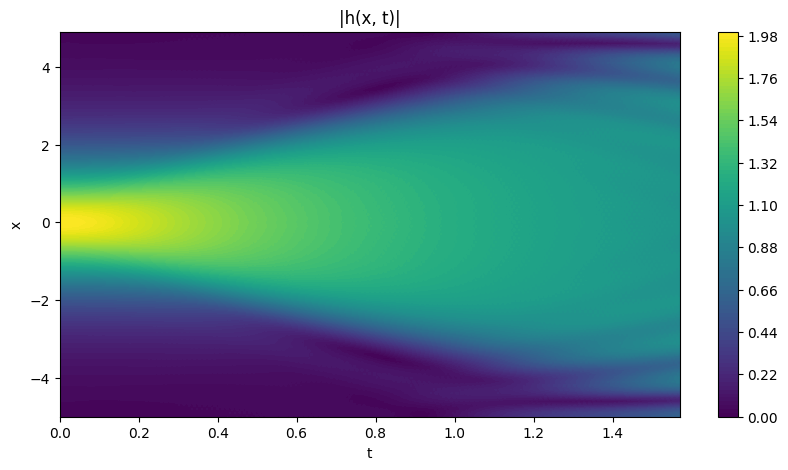

In [56]:
X, T = np.meshgrid(NS.x, time_points)

if np.any(np.isinf(magnitude)):
    raise Exception("Data contains Infs, which cannot be plotted.")

# Contour plot
plt.figure(figsize=(10, 5))
norm = Normalize(vmin=data_min, vmax=data_max)
contour = plt.contourf(T, X, magnitude.T, 100, cmap='viridis', norm=norm)

plt.colorbar(contour)

plt.xlabel('t')
plt.ylabel('x')
plt.title('|h(x, t)|')

plt.show()